In [33]:
from IPython.display import Latex
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import polyfit
import math
#plt.style.use(['seaborn-talk', 'seaborn-ticks'])
plt.style.use('seaborn-notebook')

# Aufgaben zur Vorlesung Modellbildung und Simulation 
## (Klassische Mechanik 2)

Lösen Sie die Aufgaben, indem Sie in eigenen Worten das Problem, das Modell, die gelösten Gleichungen und den verwendeten Algorithmus beschreiben. Visualisieren und diskutieren Sie die Ergebnisse und führen Sie eine kritische Analyse durch. Geben Sie den verwendeten Code zusammen mit der Lösung ab und führen Sie diesen in den Übungen vor. Sie können in Gruppen von bis zu drei Studierenden zusammenarbeiten. 
(Abgabe: 18.05.18)


## Keplerproblem
Zwei Massen M und m, die einen Abstand r zueinander besitzen, ziehen sich gegenseitig mit der Kraft

$$\vec{F}_G = −G\frac{Mm}{r^2} \vec{e}_r$$

an. $G$ ist die universelle Gravitationskonstante.

### Aufgabe 1. 
Im File Sat.txt sind die Umlaufzeiten $T$ und mittlere Radien $r$ der Umlaufbahnen von vier Satelliten angegeben (die einen Asteroiden umkreisen). Zeigen Sie, dass sich die Daten mit der Formel $T = Cr^n$ beschreiben lassen. Bestimmen Sie $n$ und $C$, indem Sie die Daten logarithmisch auftragen. Schätzen Sie den fehlenden Radius ab.

In [2]:
"""
evaluate polynomial given by constants at a point x
"""
def poly(constants, x):
    result = 0
    for i,c in enumerate(np.flip(np.array(constants), axis = 0)):
        result += c*x**i
    return result

In [3]:
# import data
data = pd.read_csv('Sat.txt',header = 0)
data.head()
data1 = data.values[[0,1,2,4],:]
data1

array([[0.44 , 0.088],
       [1.61 , 0.208],
       [3.88 , 0.374],
       [7.89 , 0.6  ]])

$$T = Cr^n$$

$$ln(T) = ln(Cr^n)$$

$$ln(T) = ln(C)+n \cdot ln(r)$$

$$T' = C' +n \cdot r'$$

Aus dieser Gleichung folgt, dass unsere transformierte Funktion $ln(T)$ in einem Log-log-Plot eine Gerade sein muss mit der Konstanten $ln(C)$ und der Steigung $n$.

Die Rücktransformation erfolgt durch die exponential Funktion $e^{x'} = x$ mit $x'$ im transformierten Raum.

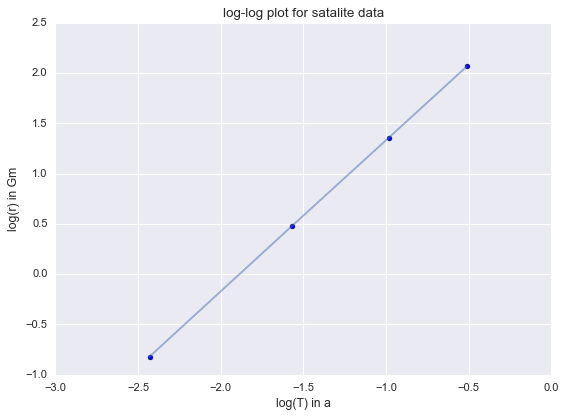

In [36]:
plt.scatter(np.log(data1[:,1]),np.log(data1[:,0]))
plt.plot(np.log(data1[:,1]),np.log(data1[:,0]), alpha = 0.5)
plt.title('log-log plot for satalite data')
plt.xlabel('log(T) in a')
plt.ylabel('log(r) in Gm')
plt.grid(True)
plt.show()

In [5]:
# using two different degrees for interpolation
deg1_log = polyfit(np.log(data1[:,0]),np.log(data1[:,1]),deg=1)
print('deg1:', deg1_log)

deg2_log = polyfit(np.log(data1[:,0]),np.log(data1[:,1]),deg=2)
print('deg2:',deg2_log)

deg1: [ 0.66507599 -1.88529751]
deg2: [ 9.81991603e-04  6.63917804e-01 -1.88612657e+00]


An der Interpolation mit den beiden Polynomen und dem verschwindenen quadratischen Term in der Interpolation zweiten Grades, kann man erkennen, dass es sich bei der Funktion um eine Gerade mit geringem Rauschen handelt (Anderenfalls wäre die Konstante des quadratischen Terms im Betrag signifikant größer).
Da es sich bei dem Plot um einen log-log Plot handelt, folgt daraus, dass die untransformierte Funktion als eine einfache Exponential Funktion der Form $T = Cr^n$ dargestellt werden kann.

In [6]:
print('missing value for satalite data:',np.round(math.e**poly(deg1_log,np.log(6.2)),3))

missing value for satalite data: 0.511


Aus Interpolation der gegebenen Werte ergibt sich für den fehlenden Radius ein ungefährer Wert von $0.511Gm$

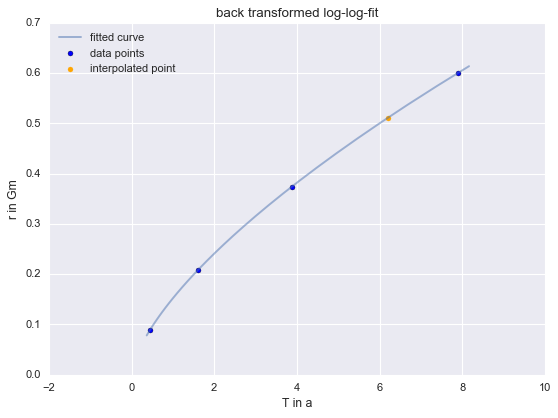

In [37]:
# fitting log log data
deg1_log = polyfit(np.log(data1[:,0]),np.log(data1[:,1]),deg=1)

# predict missing value
new_point = math.e**poly(deg1_log,np.log(6.2))

# plot back transformed log log interpolation and data points, including missing point
X = [i for i in np.arange(-1,np.log(9),0.1)]
plt.plot([math.e**x for x in X],[math.e**poly(deg1_log,x) for x in X], alpha = 0.5)
plt.scatter(data1[:,0],data1[:,1])
plt.scatter(data.values[3,0],new_point,color = 'orange')
plt.title('back transformed log-log-fit')
plt.xlabel('T in a')
plt.ylabel('r in Gm')
plt.legend(['fitted curve','data points','interpolated point'], framealpha = 0.5, loc = 0)
plt.grid(True)
plt.show()

### Aufgabe 2
Schreiben Sie ein Programm, das die Differentialgleichung 

$$m\ddot{\vec{r}} = -G\frac{Mm}{r^3}\vec{r}$$

$$\dot{\vec{r}} = \vec{v}$$
$$\Rightarrow m\dot{\vec{v}} = -G\frac{Mm}{r^3}\vec{r}$$

löst und visualisieren Sie die Bahnkurve der Erde um die Sonne. Verwenden Sie als Anfangsgeschwindigkeit $(0.0, 29.8)\cdot 10^3\frac{m}{s}$ und den Anfangsort der Erde $(1.4960, 0.0)\cdot 10^{11}\frac{m}{s}$ (Die Sonne ruhe anfänglich im Ursprung). Uberprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung numerisch.

Energie:
$$E_{kin} = \frac{1}{2}mv^2$$

$$E_{pot} = \frac{-G mM}{r}$$

Impuls:
$$ E_{kin} = \frac{p^2}{2m}$$

$$\Rightarrow p = \sqrt{2mE_{kin}}$$

$$\vec{p} = m\vec{v}^2$$

Drehimpuls:
$$\vec{L} = \vec{p} \times \vec{r}$$

In [260]:
GM = 4*np.pi*np.pi 
#GM = 1.98855 * 10**30# G*Msun
m = 1

def earth(id, r, v, t):            # return the eqns of motion
    if (id == 0): return v         # velocity, dr/dt
    s = np.linalg.norm(np.array([r[0],r[1],0]))  # $s=|\vec{r}|$
    return -GM*r/(s*s*s)           # accel dv/dt, faster than s**3  

def leapfrog(lfdiffeq, r0, v0, t, h):       # vectorized leapfrog
    """ vector leapfrog method using numpy arrays.
        It solves general (r,v) ODEs as: 
        dr[i]/dt = f[i](v), and dv[i]/dt = g[i](r).
        User supplied lfdiffeq(id, r, v, t) returns
        f[i](r) if id=0, or g[i](v) if id=1.
        It must return a numpy array if i>1 """
    hh = h/2.0
    r1 = r0 + hh*lfdiffeq(0, r0, v0, t)     # 1st: r at h/2 using v0    @\lbl{line:lf1}@
    v1 = v0 +  h*lfdiffeq(1, r1, v0, t+hh)  # 2nd: v1 using a(r) at h/2 @\lbl{line:lf2}@
    r1 = r1 + hh*lfdiffeq(0, r0, v1, t+h)   # 3rd: r1 at h using v1     @\lbl{line:lf3}@
    return r1, v1

def trajectory_leapfrog(ode, r, v, t_start, t_end , h):
    result = [r,v]
    e_kin = [0.5*m*np.linalg.norm(v)**2]
    e_pot = [-m*GM/np.linalg.norm(r)]
    p = [np.array(m*v)]
    L = [np.cross(r,p[-1])]
    #L = [m*np.linalg.norm(r)*np.linalg.norm(v)]
    for t in np.arange(t_start, t_end, h):
        r,v = leapfrog(ode, r, v, t, h)
        result += [r,v]
        e_kin += [0.5*m*np.linalg.norm(v)**2]
        e_pot += [-m*GM/np.linalg.norm(r)]
        p += [np.array(m*v)]
        L += [np.cross(r,p[-1])]
        #L += [m*np.linalg.norm(r)*np.linalg.norm(v)]
    return np.array(result).reshape(-1,4), np.array(e_kin), np.array(e_pot), p, np.array(L)

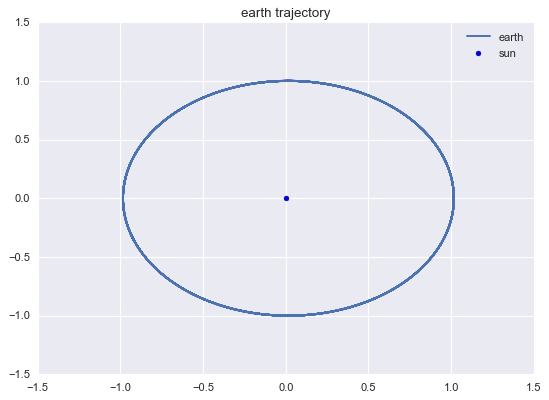

In [286]:
# initial x,y position for earth   
r = np.array([1.4960*10**11,0])    
v = np.array([0,29.8*10**2])

#test coordinates
r = np.array([1.017, 0.0])    
v = np.array([0.0, 6.179])

t, h = 0.0, 0.01
t_start = 0.
t_end = 10
sol, e_kin, e_pot, p, L = trajectory_leapfrog(earth, r, v, t_start, t_end, h)

plt.plot(sol[:,0],sol[:,1])
plt.scatter(0,0)
plt.legend(['earth','sun'])
plt.title('earth trajectory')
plt.show()

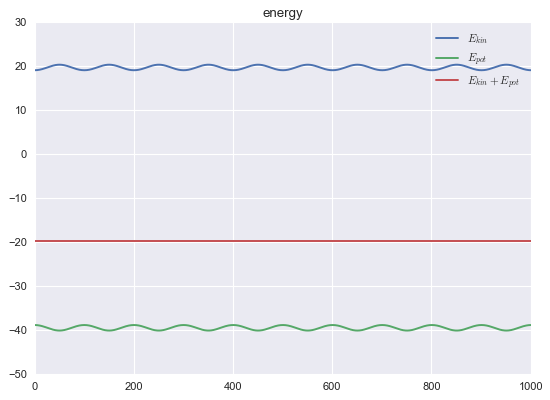

In [255]:
plt.plot(e_kin)
plt.title('energy')
plt.plot(e_pot)
plt.plot(np.add(e_kin,e_pot))
plt.legend([r'$E_{kin}$',r'$E_{pot}$',r'$E_{kin}+E_{pot}$'])
plt.show()

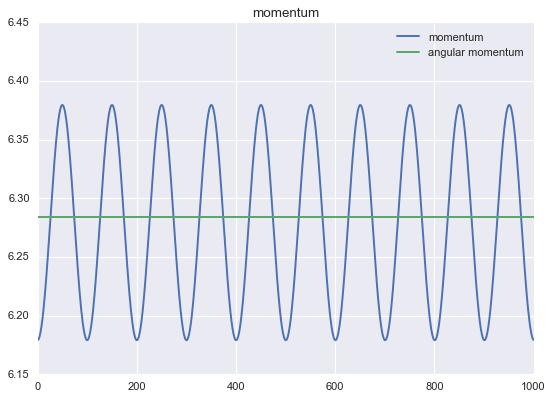

In [268]:
plt.plot([np.linalg.norm(P) for P in p])
plt.plot(L)
plt.title('momentum')
plt.legend(['momentum','angular momentum'], framealpha = 0.5)
plt.ylim(6.15,6.45)
plt.show()

Der Drehimpuls ist konstant, der Impuls schwankt über das Jahr hinweg, was an der schwankenden kinetischen Ernergie liegt.

### Aufgabe 3
Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung analytisch. Verwenden Sie dazu Polarkoordinaten und leiten Sie die Bewegungsgleichungen in Polarkoordinaten her:

$$ m(\ddot{r}-r\dot{\theta}^2) = -G \frac{mM}{r^2}$$

$$m(r\ddot{\theta}+2\dot{r}\dot{\theta})= 0$$

In [271]:
# Ekaterina

### Aufgabe 4
Variieren Sie die Anfangsgeschwindigkeit der Erde und beschreiben Sie die verschiedenen Bahnformen, die sich ergeben.

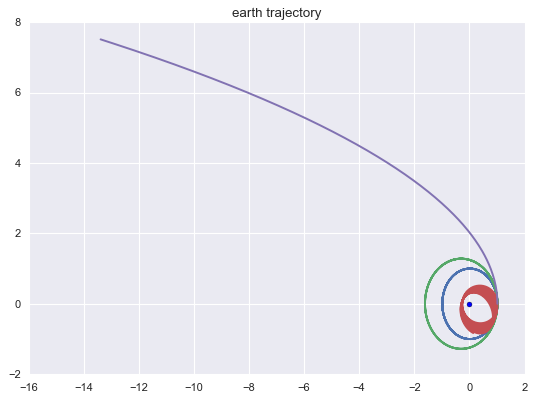

In [311]:
r= np.array([1.017, 0.0])    
v_list = [np.array([0.0, 6.179]),np.array([0.0, 6.9]),np.array([0.0, 4]),np.array([0.0, 8.8])]

for v in v_list:
    t, h = 0.0, 0.01
    t_start = 0.
    t_end = 5
    sol, e_kin, e_pot, p, L = trajectory_leapfrog(earth, r, v, t_start, t_end, h)
    plt.plot(sol[:,0],sol[:,1])
plt.scatter(0,0)
plt.title('earth trajectory')
plt.show()

Für eine bestimmte Range entstehen stabile Umlaufbahnen mit unterschiedlichen Halbachsen. Ab einem bestimmten Punkt ist die Fluchtgeschwindigkeit erreicht und der Planet kann nicht mehr von der Sonne eingefangen werden (Die Bewegungen teilen sich hier nochmal in Parabolische und hyperbolische Trajektorien auf). Unterschreitet der Planet eine bestimmte Geschwindigkeit fangen die Halbachsen an um das Zentralgestirn zu rotieren. Hier gibt es auch wieder stabile rotierende Umlaufbahnen. Sobald ein Grenzert unterschritten wird, fällt der Planet so nah in die Sonne, dass er wiederum aus der Umlaufbahn katapultiert wird und das System verlässt. Im Extremfall stür

### Aufgabe 5
Beschreiben Sie mit Hilfe Ihres Programms die Bewegung zweier fast gleich großer Massen (Zweikörperproblem). Denken Sie an die Impulserhaltung!

### Aufgabe 6
Drei Sterne seien anfangs in Ruhe mit den folgenden Massen und Positionen (arbitrary
units)

|   | mass  | x  | y  |
|---|---|---|---|
| star 1  | 150  | 3  | 1  |
| star 2  | 200  | -1  | -2  |
| star 3  | 250  |  -1 |  1 |

(Die drei Sterne seien in der xy-Ebene.)

a)
Zeigen Sie, dass die Bewegungsgleichung fur Position $\vec{r_1}$ des ersten Sterns gegeben ist durch:

$$\ddot{\vec{r_1}} = Gm_2\frac{\vec{r_2}-\vec{r_1}}{\mid\vec{r_2}-\vec{r_1}\mid} + Gm_3\frac{\vec{r_3}-\vec{r_1}}{\mid\vec{r_3}-\vec{r_1}\mid}$$

und stellen Sie die Gleichungen fur $\vec{r_2}$ und $\vec{r_3}$ der beiden anderen Sterne auf.

b)
Setzen Sie G = 1 und schreiben Sie ein Programm, das die Bewegungsgleichungen löst. Plotten Sie y als Funktion von x und animieren Sie die Bewegung. Die Sterne bewegen sich sehr schnell, wenn sie sich nähern und sind sehr langsam, wenn sie weit voneinander entfernt sind. Eine adaptive Methode könnte deshalb nützlich sein.

In [270]:
# a) Ekaterian

# Stuff

In [65]:
r = 0.088
print(deg1[1]*r**deg1[0])

-0.37443864408485283


In [57]:
deg2_ret = math.e**deg1_log
print(deg2_ret)
print(poly(deg2,0.44))

[1.94463828 0.1517839 ]
0.09257901767473829


In [55]:

deg2 = polyfit(data1[:,0],data1[:,1],deg=2)
deg2

array([-0.00375838,  0.09931925,  0.04960617])

In [34]:
# interpoliere fehlenden Radius
poly(polyfit(data1[:,0],data1[:,1],deg=2),6.2)

0.520913492844291

In [44]:
np.log(math.e)

1.0